In [29]:
# On importe les bibliotèques pour la gestion d'objet et le traitement de données
import matlab
import matlab.engine as engine
import numpy as np
import scipy.io as scipy
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# On importe les bibliotèques associées aux méthodes d'apprentissage supervisé
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.config.run_functions_eagerly(True)

In [3]:
# On démarre l'environnement virtuel MATLAB
eng = engine.start_matlab()

In [4]:
# On ajoute le chemin d'accès vers l'emplacement de la fonction 
eng.addpath(r"C:\Users\Utilisateur\OneDrive - ETS\CRIAQ-REAR\Maitrise LB\Functions", nargout = 0)
eng.add_all_paths(r"C:\Users\Utilisateur\OneDrive - ETS\CRIAQ-REAR\Maitrise LB", nargout = 0)

In [5]:
# On teste la fonction de perte
eng.eval(f"run('{"launch_environnement.m"}')", nargout = 0)
eng.eval(f"run('{"test_multiQWL_cost_function.m"}')", nargout = 0)

# On nettoie l'environnement
eng.eval('clear all', nargout = 0)

In [6]:
# on définit les paramètres de l'environnement
T = 23 # température
P = 100800 # static pressure
H = 50 # relative humidity

# on définit les paramètres du support fréquentiel
fmin = 1 # fréquence minimale (Hz)
fmax = 3000 # fréquence maximale (Hz)
points = 7 # nombre de points sur le spectre

# On convertit les données en format MATLAB
T_matlab = matlab.double([T])  # Convertir en tableau MATLAB
P_matlab = matlab.double([P])
H_matlab = matlab.double([H])
fmin_matlab = matlab.double([fmin])
fmax_matlab = matlab.double([fmax])
points_matlab = matlab.double([points])

# Appeler la fonction MATLAB (par exemple create_environnement)
air_matlab, w_matlab = eng.create_environnement(T_matlab[0], P_matlab[0], H_matlab[0], fmin_matlab[0], fmax_matlab[0], points_matlab[0], nargout = 2)

In [7]:
# On importe le dataset (création du trainset et du testset)
eng.load(r'C:\Users\Utilisateur\OneDrive - ETS\CRIAQ-REAR\Maitrise LB\Caractérisation inverse\CI pour configurations\CI multiQWL\data.mat', nargout = 0)
data_matlab  = eng.workspace['data']
data = {field: np.array(data_matlab[field]) for field in data_matlab.keys()}
x = data['X']
y = data['Y']

In [8]:
# On prépare les données pour l'apprentissage
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42)

# On convertit les données en float32
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)

print("Taille de x_train:", x_train.shape)
print("Taille de y_train:", y_train.shape)

# On crée les datasets TensorFlow à partir des valeurs extraites
trainset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size = 100).batch(32, drop_remainder = True)
testset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(buffer_size = 100).batch(32, drop_remainder = True)

Taille de x_train: (800, 7)
Taille de y_train: (800, 8)


In [9]:
# On teste les données du trainset
for x_batch, y_batch in trainset.take(1):
    print(x_batch.shape)  # Devrait afficher (32, 7)
    print(y_batch.shape)  # Devrait afficher (32, 8)
    print("x_batch sample:", x_batch.numpy()[0])
    print("y_batch sample:", y_batch.numpy()[0])

(32, 7)
(32, 8)
x_batch sample: [0.00400717 0.8316462  0.44949225 0.5112053  0.7518333  0.77998745
 0.60347456]
y_batch sample: [0.00694347 0.0029629  0.00693993 0.00347775 0.48699436 0.98735744
 0.1884232  0.7931485 ]


In [83]:
class CustomModel(tf.keras.Model):
    def __init__(self, hidden_layers_dim, input_dim, output_dim, air_matlab, w_matlab):
        super(CustomModel, self).__init__()
        self.hidden_layers_dim = hidden_layers_dim
        self.air_matlab = air_matlab
        self.w_matlab = w_matlab
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.input_layer = tf.keras.layers.Dense(self.input_dim)
        self.dense1 = tf.keras.layers.Dense(hidden_layers_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_layers_dim, activation='relu')
        self.dense3 = tf.keras.layers.Dense(hidden_layers_dim, activation='relu')
        self.dense4 = tf.keras.layers.Dense(hidden_layers_dim, activation='relu')
        self.output_layer = tf.keras.layers.Dense(self.output_dim, activation='linear')

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.output_layer(x)
        return output

    def train_step(self, data):
        x_batch, y_batch = data  # Obtenez les entrées et les sorties du batch

        with tf.GradientTape() as tape:
            y_pred = self.call(x_batch)
            print("Shape of x_batch:", x_batch.shape)
            print("Shape of y_batch:", y_batch.shape)
            print("Shape of y_pred:", y_pred.shape)

            loss = custom_loss(x_batch, y_pred, self.air_matlab, self.w_matlab)
            print("loss dans fonction d'appel matlab", loss)
            print("Shape of loss before reshape:", loss.shape)
            if loss.shape != ():
                loss = tf.reshape(loss, [])
            print("Shape of loss after reshape:", loss.shape)
            print("loss in trainstep : ", loss)
            tf.print("tf.print loss in trainstep : ", loss)

        # Calculer les gradients et les appliquer
        print("self.variables : ", self.trainable_variables)
        gradients = tape.gradient(loss, self.trainable_variables)

        # Vérification des formes de gradients
        for var, grad in zip(self.trainable_variables, gradients):
            if grad is None:
                print(f"Gradient for variable {var.name} is None")
            else:
                print(f"Shape of gradient for variable {var.name}:", grad.shape)

        # Vérifiez si un gradient est de forme incorrecte
        for grad in gradients:
            if grad is not None and grad.shape == ():
                print(f"Unexpected scalar gradient: {grad}")

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

In [84]:
def custom_loss(x_batch_tf_symb, y_pred_tf_symb, air_matlab, w_matlab):
    # On évalue la fonction d'appel après avoir évaluer les tenseurs symboliques
    wrapper = multiQWL_cost_function_python_wrapper(air_matlab, w_matlab)
    loss_value = tf.py_function(func = wrapper, inp = [x_batch_tf_symb, y_pred_tf_symb], Tout = tf.float32)
    print("print, loss value : ", loss_value)
    tf.print("tf print, loss value : ", loss_value)
    loss_value = tf.reduce_mean(loss_value)
    print("reduced loss : ", loss_value)
    return loss_value
    
def multiQWL_cost_function_python_wrapper(air_matlab, w_matlab):
    def wrapped_cost_function(x_batch_tf_stat, y_pred_tf_stat):
        return multiQWL_cost_function_python(x_batch_tf_stat, y_pred_tf_stat, air_matlab, w_matlab)
    return wrapped_cost_function

In [85]:
# On définit la fonction d'appel de la fonction de perte définit sur matlab qui prend en entrée des tenseurs statiques
def multiQWL_cost_function_python(x_batch_tf_stat, y_pred_tf_stat, air_matlab, w_matlab):
    # Convertir les tenseurs en Numpy
    x_batch_np = x_batch_tf_stat.numpy()
    y_batch_np = y_pred_tf_stat.numpy()
    
    # Convertir en format MATLAB
    x_batch_matlab = matlab.double(x_batch_np.tolist())
    y_batch_matlab = matlab.double(y_batch_np.tolist())
    
    # Appeler la fonction MATLAB pour calculer la perte
    loss = eng.multiQWL_cost_function(x_batch_matlab, y_batch_matlab, air_matlab, w_matlab)
    print("loss dans fonction d'appel matlab", loss)
    return loss

In [86]:
# On définit les hyperparamètres nécessaires à l'apprentissage
input_dim = x_train.shape[1]  # Dimension de l'entrée (nombre de colonnes)
output_dim = y_train.shape[1] # Dimension de la sortie (nombre de colonnes)
hidden_units = 10  # Nombre de neurones dans la couche cachée
learning_rate = 0.01  # Taux d'apprentissage
epochs = 5  # Nombre maximum d'itérations
goal = 1e-5  # Seuil d'erreur (utilisé pour l'early stopping)
max_fail = 6  # Nombre maximum d'échecs de validation (patience pour l'early stopping)

In [87]:
# On crée et compile le modèle personnalisé
model = CustomModel(hidden_units, input_dim, output_dim, air_matlab, w_matlab)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate))

In [88]:
# On implémente un callback d'early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = max_fail, min_delta = goal)

# On crée et on compile le modèle personnalisé
history = model.fit(trainset, epochs = epochs, callbacks = [early_stopping])

Epoch 1/5
Shape of x_batch: (32, 7)
Shape of y_batch: (32, 8)
Shape of y_pred: (32, 8)
loss dans fonction d'appel matlab 320.0
print, loss value :  tf.Tensor(320.0, shape=(), dtype=float32)
tf print, loss value :  320
reduced loss :  tf.Tensor(320.0, shape=(), dtype=float32)
loss dans fonction d'appel matlab tf.Tensor(320.0, shape=(), dtype=float32)
Shape of loss before reshape: ()
Shape of loss after reshape: ()
loss in trainstep :  tf.Tensor(320.0, shape=(), dtype=float32)
tf.print loss in trainstep :  320
self.variables :  [<KerasVariable shape=(7, 7), dtype=float32, path=dense_72/kernel>, <KerasVariable shape=(7,), dtype=float32, path=dense_72/bias>, <KerasVariable shape=(7, 10), dtype=float32, path=dense_73/kernel>, <KerasVariable shape=(10,), dtype=float32, path=dense_73/bias>, <KerasVariable shape=(10, 10), dtype=float32, path=dense_74/kernel>, <KerasVariable shape=(10,), dtype=float32, path=dense_74/bias>, <KerasVariable shape=(10, 10), dtype=float32, path=dense_75/kernel>, <Ke

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 1 values, but the requested shape has 256 [Op:Reshape] name: 

KeyError: 'val_loss'

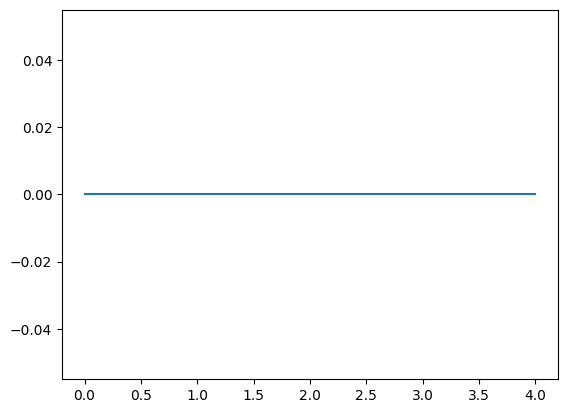

In [30]:
# On affiche le suivi de l'apprentissage
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# On évalue le modèle sur le testset
loss = model.evaluate(testset)
print("Test Loss:", loss.numpy())